In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Dataframe that has info on airport coordinates
sw_data=pd.read_csv("FINAL_EDGE_TABLE.csv",usecols=['Origin_Airport_Code','origin_lat','origin_long','passengers','sum_departures_performed'])
renaming={'Origin_Airport_Code':'IATA','origin_lat':'LATITUDE','origin_long':'LONGITUDE','passengers':"PASSENGERS",'sum_departures_performed':'DEPARTURES'}
sw_data.rename(columns=renaming,inplace=True)
sw_airports_location=sw_data[['IATA','LATITUDE','LONGITUDE']].drop_duplicates(keep='first').reset_index(drop=True)
sw_airports_location

,IATA,LATITUDE,LONGITUDE
0,ABQ,35.040199,-106.609001
1,ALB,42.748299,-73.801697
2,AMA,35.219398,-101.706001
3,ATL,33.636700,-84.428101
4,AUS,30.197535,-97.662015
...,...,...,...
80,SNA,33.675701,-117.867996
81,STL,38.748697,-90.370003
82,TPA,27.975500,-82.533203
83,TUL,36.198399,-95.888100


In [3]:
#Dataframe that has info on airport demand
sw_passengers=sw_data[['IATA','DEPARTURES','PASSENGERS']]
sw_passengers=sw_passengers.groupby(['IATA']).mean().reset_index()
sw_passengers.insert(3,'AVERAGE',sw_passengers['PASSENGERS']/sw_passengers['DEPARTURES'])
sw_passengers

,IATA,DEPARTURES,PASSENGERS,AVERAGE
0,ABQ,254.888889,29756.222222,116.741935
1,ALB,176.166667,22521.000000,127.839167
2,AMA,254.500000,23229.500000,91.275049
3,ATL,320.166667,36946.388889,115.397362
4,AUS,214.000000,25781.076923,120.472322
...,...,...,...,...
80,SNA,675.428571,79748.142857,118.070431
81,STL,247.976190,29830.880952,120.297360
82,TPA,222.823529,27228.205882,122.196278
83,TUL,171.400000,18482.400000,107.831972


In [4]:
#Function that calculates the haversine distance between two sets of coordinates
from sklearn.metrics.pairwise import haversine_distances
def haversine(x,y):
    R=6371 #Radius of Earth in KM
    x_rd=np.radians(x)
    y_rd=np.radians(y)
    h=(haversine_distances([x_rd,y_rd]))[0][1]
    d=R*h #Haversine Distance
    return d

In [5]:
#Function that calculates Inertia (Total squared error)
def k_means_inertia(data,centre_labels,w):
    se=0
    for centres in np.unique(centre_labels):
        airports=data.loc[data['LABELS']==centres]
        a=airports[['LATITUDE','LONGITUDE']].values
        airport_weights=w[airports.index.tolist()]
        c_coords=data.loc[data['IATA']==centres][['LATITUDE','LONGITUDE']].values
        for i in range(a.shape[0]):
            se=se+airport_weights[i]*(haversine(list(a[i,:]),list(c_coords[0])))**2
    return se

In [6]:
#Function that runs a k-means algorithm based on haversine distance
def k_means_haversine(coordinates,codes,weights,no_of_clusters):
    #Setting some initial variables
    distance_matrix=np.zeros((codes.size,no_of_clusters))
    counter=0
    
    #Randomly chooses k points that serve as the initial cluster centres
    idx=np.random.choice(codes.size,no_of_clusters,replace=False)
    new_centres=list((codes[idx]))
    initial_centres=set(new_centres)
    old_centres=[]
    centres_coords=coordinates[idx,:]   

    #Running a loop till the cluster centres converge
    while(set(old_centres)!=set(new_centres)):

        #The cluster centres of the previous iteration become old clusters now
        old_centres=new_centres

        #Calculates the distance between each point and every centre and stores in the data matrix
        k,l=0,0
        for i in coordinates:
            for j in centres_coords:
                distance_matrix[k][l]=haversine(list(i),list(j))
                l=l+1
            l=0
            k=k+1

        #Assigns each point to a cluster
        #Labels each point with the cluster centre closest to it and adds it as an attribute to the dataframe
        labels=[]
        for i in distance_matrix:
            i=list(i)
            labels.append(new_centres[i.index(min(i))])
        sw_airports_location['LABELS']=labels

        #For each cluster, finds out the weighted average of all latitudes and longitudes (Virtual point)
        #Makes that point the cluster centre whose haversine distance from the virtual point is least
        #Assigns all new cluster centres coordinates by replacing old ones
        centres_coords=[]
        for centres in np.unique(labels):
            airports=sw_airports_location.loc[sw_airports_location['LABELS']==centres]
            a=airports[['LATITUDE','LONGITUDE']].values
            c_weights=weights[airports.index.tolist()]
            h_distances=np.zeros(a.shape[0])
            for i in range(h_distances.size):
                h_distances[i]=haversine(list(a[i,:]),[0,0])
            j=np.average(h_distances,weights=c_weights)
            centres_coords.append(a[np.argmin(np.abs(h_distances-j)),:])
        centres_coords=np.array(centres_coords)
        
        #Finding the corresponding airports to the newly found cluster centre coordinates
        new_centres=[]
        for i in centres_coords:
            new_centres.append(sw_airports_location.iloc[sw_airports_location.index[(sw_airports_location['LATITUDE']==i[0]) & 
                                                             (sw_airports_location['LONGITUDE']==i[1])].tolist()[0]]['IATA'])

        #Increasing the counter for every iteration
        counter=counter+1

        if(counter==20):
            #Algorithm did not converge
            return ([],0,[])

    
    #Algorithm converged
    return (new_centres,k_means_inertia(sw_airports_location,labels,weights),labels)

In [7]:
#Defining some pre-requisite values
n=100
airport_coordinates=sw_airports_location.values[:,1:3]
airport_codes=sw_airports_location.values[:,0]
weight=np.array(sw_passengers['AVERAGE'])
sw_airports=sw_airports_location['IATA'].tolist()

In [8]:
#List to maintain inertias for different k values
av_inertia=[]

#Running k_means n times for a range of values of k: 5 to 12
for k in range(5,13):
    converged_counter=0
    sum_inertia=0
    
    #Performing the algorithm until it converges n times
    #Calculating the average inertia for the n times it converged
    while(converged_counter!=n):
        _, inertia, _ =k_means_haversine(airport_coordinates,airport_codes,weight,k)
        if(inertia!=0):
            converged_counter=converged_counter+1
            sum_inertia=sum_inertia+inertia
    av_inertia.append(sum_inertia/n)

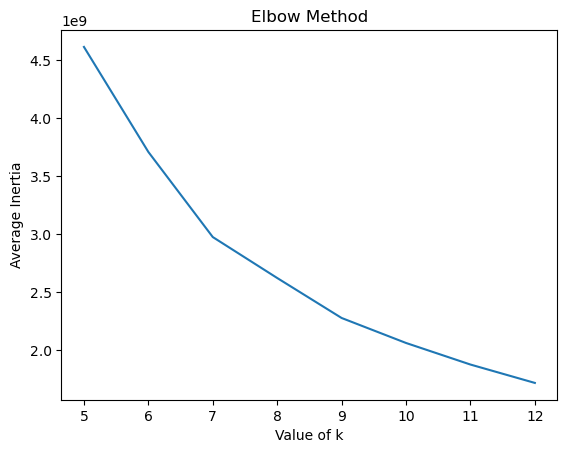

In [9]:
#Plotting the average inertias against no. of clusters
#Helps determine the ideal value of "k" via the elbow method
plt.plot(range(5,13),av_inertia)
plt.xlabel("Value of k")
plt.ylabel("Average Inertia")
plt.title("Elbow Method")
plt.show()

**Selected value of k from the Elbow Method = 7**

In [10]:
#Dictionary that stores the frequency of how many times each airport appeared as a cluster centre
cc_frequency_7={i:0 for i in sw_airports}
#Counter to check no. of times algorithm converged
converged_counter=0
#No. of clusters selected by elbow method
selected_k=7
#Additional dataframe to store the cluster centres for each airport in each iteration
sw_labels_7=pd.DataFrame(sw_airports,columns=['IATA'])

#Performing the algorithm until it converges n times
#Counting the number of times each airport comes out as a cluster centre
#Keeping a record of the cluster centres for each airport all the n times it converged
while(converged_counter!=n):
    obtained_centres, _, obtained_labels =k_means_haversine(airport_coordinates,airport_codes,weight,selected_k)
    if(obtained_centres):
        converged_counter=converged_counter+1
        s='Label_'+str(converged_counter)
        sw_labels_7[s]=obtained_labels
    for i in obtained_centres:
        cc_frequency_7[i]=cc_frequency_7[i]+1

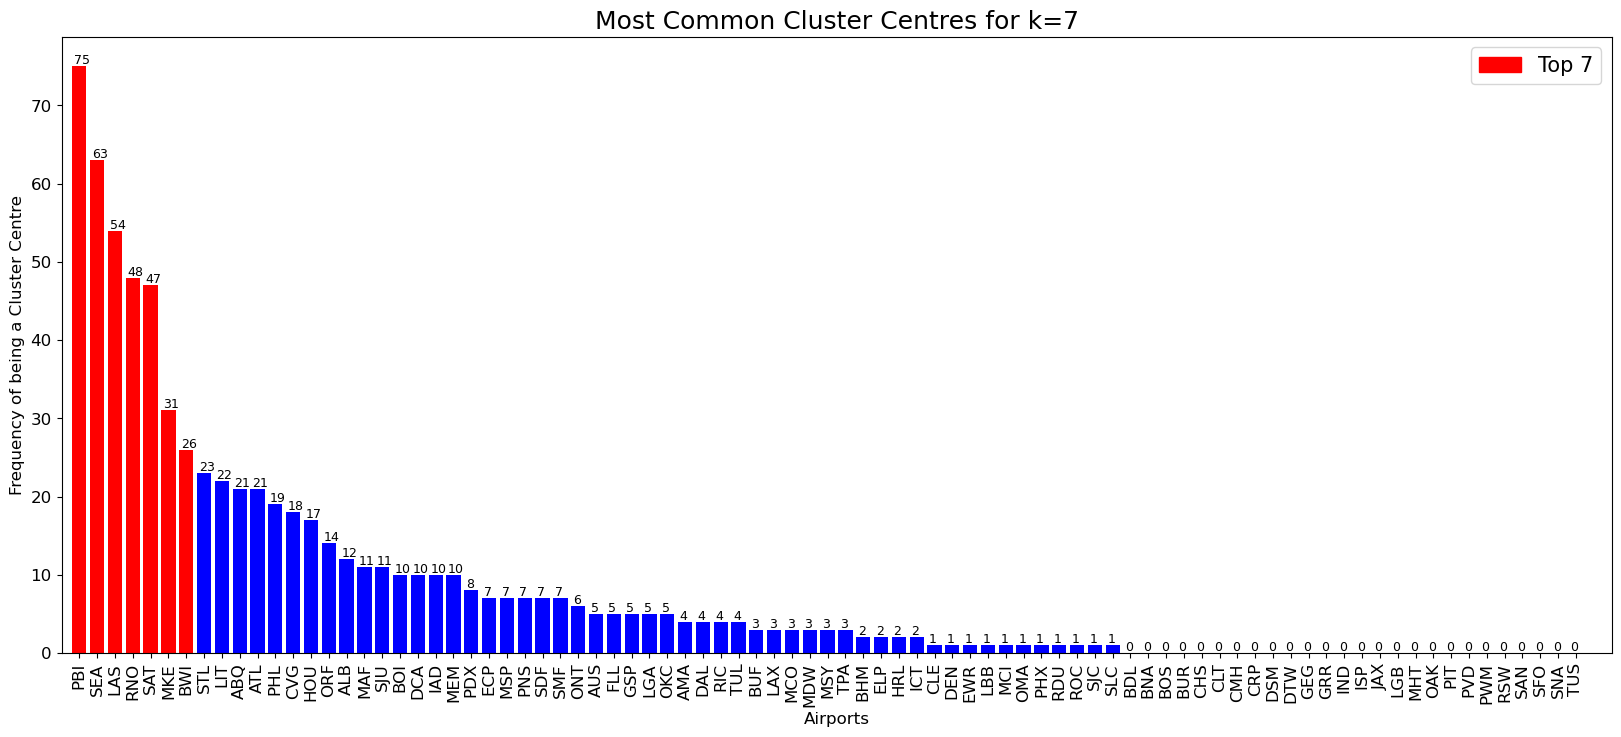

In [11]:
#New dictionary that contains sorted frequencies
common_centres_7=dict(sorted(cc_frequency_7.items(),key=lambda x:x[1],reverse=True))
#List to store the 7 most common cluster centres
ccc=sorted(list(common_centres_7.keys())[:7])
#Storing the coordinates of these 7 centres
final_centres=sw_airports_location.loc[sw_airports_location['IATA'].isin(ccc)].iloc[:,1:3].values

#Defining a colour bar
colors_7=7*['r']+78*['b']
top_7 = mpatches.Patch(color='r', label='Top 7')

#Bar Plot of cluster centre frequency
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(20,8))
plt.bar(common_centres_7.keys(), common_centres_7.values(),color=colors_7)
plt.xticks(rotation='vertical')
plt.xlim(-1,86)
plt.rcParams.update({'font.size': 9})
for index, value in enumerate(common_centres_7.values()):
    plt.text(index-0.3,value+0.3,str(value))
plt.rcParams.update({'font.size': 15})
plt.title("Most Common Cluster Centres for k=7")
plt.xlabel("Airports")
plt.ylabel("Frequency of being a Cluster Centre")
plt.legend(handles=[top_7])
plt.show()

In [12]:
#Finding the most common centre(mode) for each airport
sw_labels_7['MCL']=sw_labels_7.mode(axis=1)[0]
to_drop=['Label_'+str(i) for i in range(1,101)]
sw_labels_7.drop(columns=to_drop,inplace=True)

#For all those airports whose most common centre is not a top 7 airport, find the top 7 airport which is closest to it
#Assign that centre as its most common centre
for (index,row) in sw_labels_7.iterrows():
    if row['MCL'] not in ccc:
        a=airport_coordinates[index,:]
        min_dist=np.inf
        for (i,j) in enumerate(final_centres):
            dist=haversine(list(a),list(j))
            if dist<min_dist:
                min_dist=dist
                na=ccc[i]
        row['MCL']=na

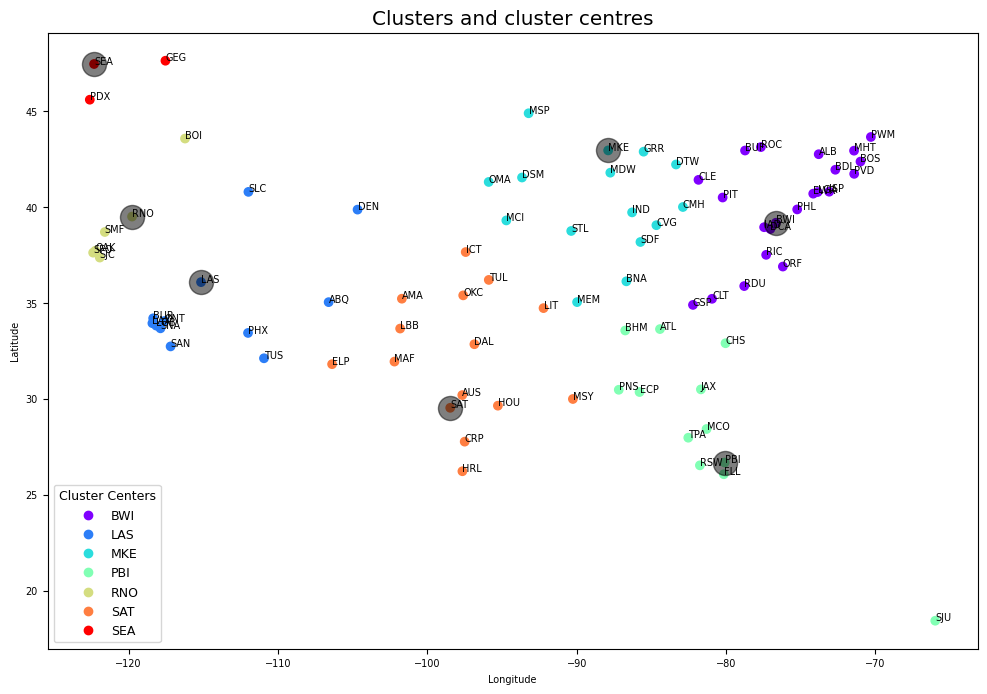

In [13]:
#Creating a scatter plot of all airports, with each airport belonging to the cluster of its most common cluster centre
plt.rcParams.update({'font.size': 7})
plt.figure(figsize=(12,8))
scatter=plt.scatter(airport_coordinates[:,1],airport_coordinates[:,0],c=pd.Categorical(sw_labels_7['MCL'].tolist()).codes,cmap=plt.cm.rainbow)
for i,txt in enumerate(airport_codes):
        plt.annotate(txt,(airport_coordinates[i,1],airport_coordinates[i,0]))
plt.scatter(final_centres[:,1],final_centres[:,0],c='k',marker='o',s=300,alpha=0.5)
plt.rcParams.update({'font.size': 12})
plt.title('Clusters and cluster centres')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.rcParams.update({'font.size': 9})
plt.legend(handles=scatter.legend_elements()[0],labels=ccc,title="Cluster Centers",loc='lower left')
plt.show()